In [1]:
from blade import ExperimentLogger
from blade import plot_convergence, plot_experiment_CEG
import os

logger = ExperimentLogger('results/MA_BBOB', True)

Failed to update token costs. Using static costs.
/home/neocortex/.cache/pypoetry/virtualenvs/blade-xXF9vABH-py3.10/lib/python3.10/site-packages/tokencost/constants.py:69: RuntimeWarning: coroutine 'update_token_costs' was never awaited
  logger.error("Failed to update token costs. Using static costs.")


In [2]:
methods, problems = logger.get_methods_problems()
print(methods)
print(problems)

['LLaMEA-1', 'LLaMEA-2', 'LLaMEA-3', 'LLaMEA-4', 'LLaMEA-5']
['MA_BBOB']


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


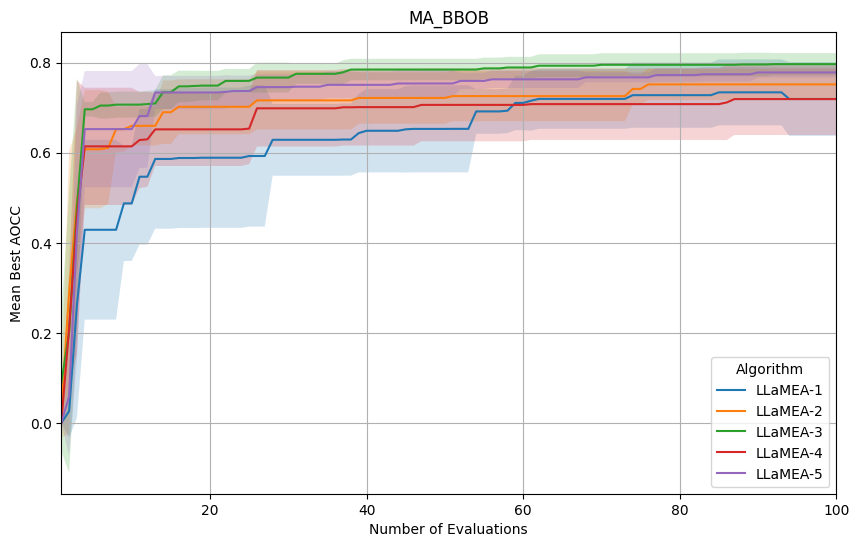

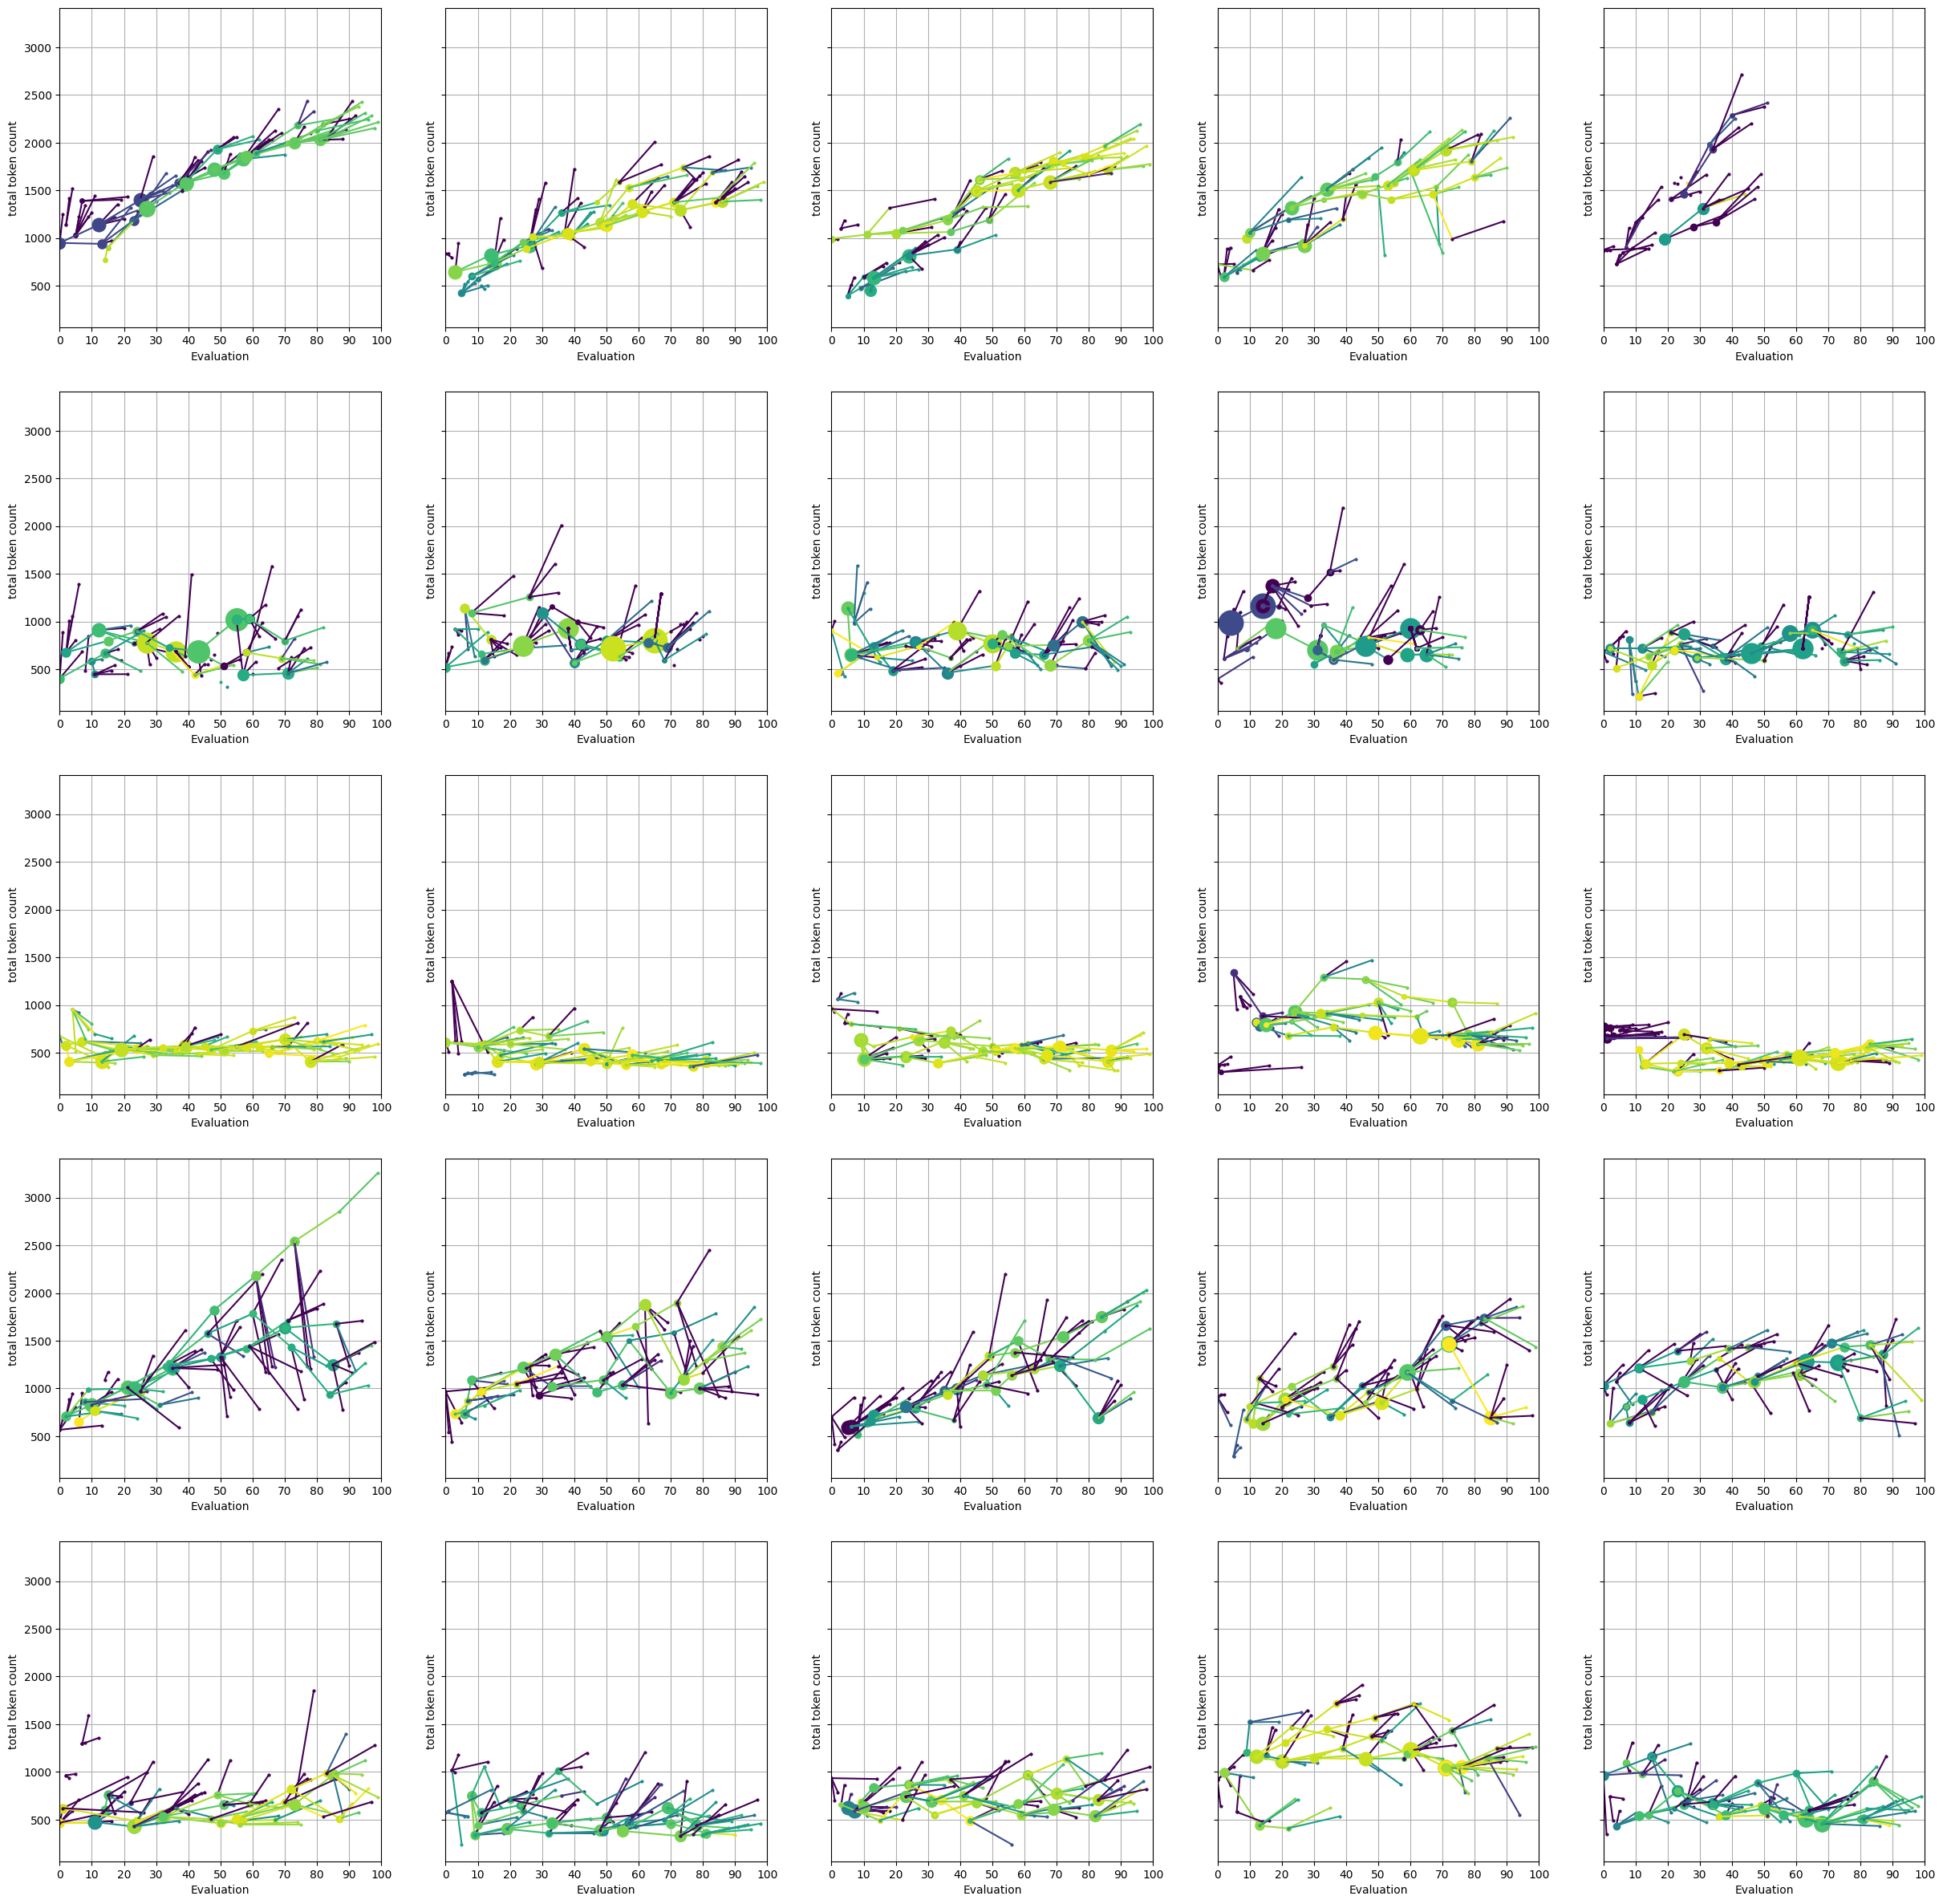

0.8100056913544971
1382    import numpy as np\n\nclass AdaptiveDE:\n    d...
Name: code, dtype: object
1382    AdaptiveDE
Name: name, dtype: object


In [4]:
import numpy as np
import json
data = logger.get_problem_data('MA_BBOB').copy()

data = data.drop(columns=['description', 'id', 'configspace', 'generation', 'feedback', 'error', 'metadata'])


# method_data = data[data['method_name'] == "RandomSearch"].copy()
# method_data = method_data.sort_values(by=['seed', '_id'])
# method_data

plot_convergence(logger, metric="AOCC", save=False, budget=100)
plot_experiment_CEG(logger, save=False, budget=100)

# get max fitness and show code and name
print(data['fitness'].max())
print(data[data['fitness'] == data['fitness'].max()]['code'])
print(data[data['fitness'] == data['fitness'].max()]['name'])
# now write the best code to a file (the code is json encoded and should first be decoded)
best_code = data[data['fitness'] == data['fitness'].max()]['code'].values[0]

with open("best_code.py", "w") as f:
    f.write(best_code)


In [ ]:
plot_convergence(logger, metric="AOCC", save=True, budget=100)
plot_experiment_CEG(logger, save=True, budget=100, max_seeds=3)